## Problem statement

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [37]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Load the data

In [6]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [8]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [13]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [16]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [18]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [20]:
# List out all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize distribution of classes

In [26]:
# Function to visualize distribution of classes in the training dataset.
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,melanoma,438
1,pigmented benign keratosis,462
2,nevus,357
3,basal cell carcinoma,376
4,actinic keratosis,114
5,squamous cell carcinoma,181
6,vascular lesion,139
7,seborrheic keratosis,77
8,dermatofibroma,95


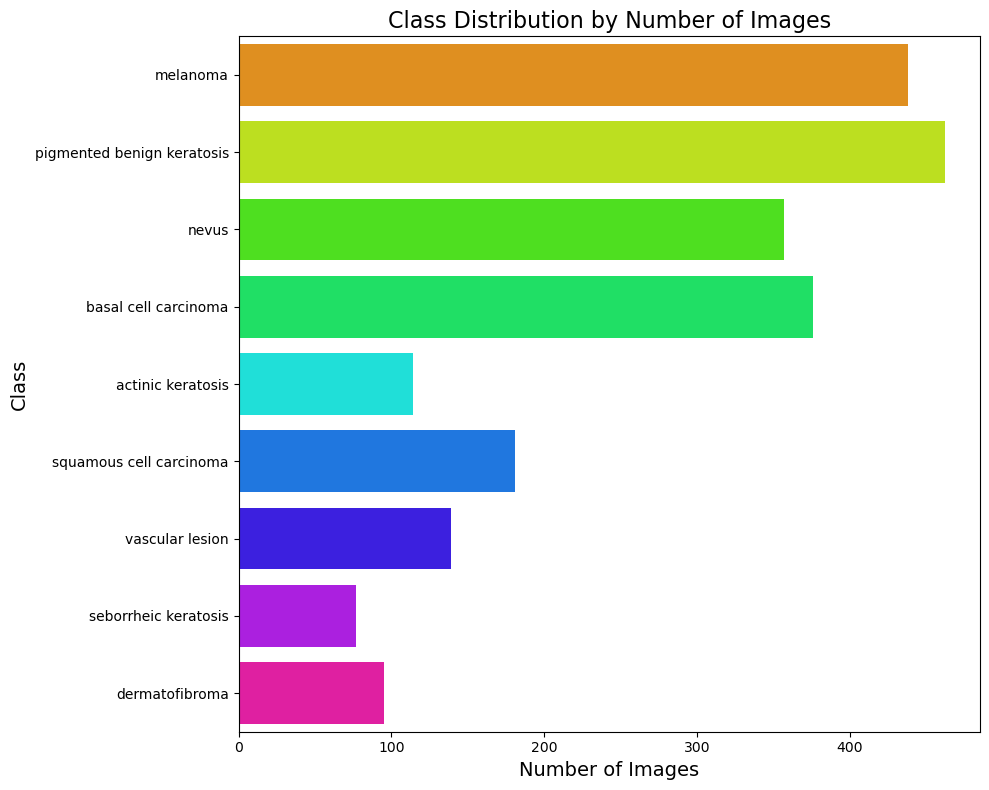

In [69]:
palette = sns.color_palette("hsv", len(df["Class"].unique()))  # Use "hsv" for a colorful gradient

plt.figure(figsize=(10, 8))
sns.barplot(
    x="No. of Image",
    y="Class",
    data=df,
    palette=palette
)

plt.xlabel("Number of Images", fontsize=14)
plt.ylabel("Class", fontsize=14)
plt.title("Class Distribution by Number of Images", fontsize=16)
plt.tight_layout()

plt.show()

### Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

2025-01-15 18:09:32.147881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


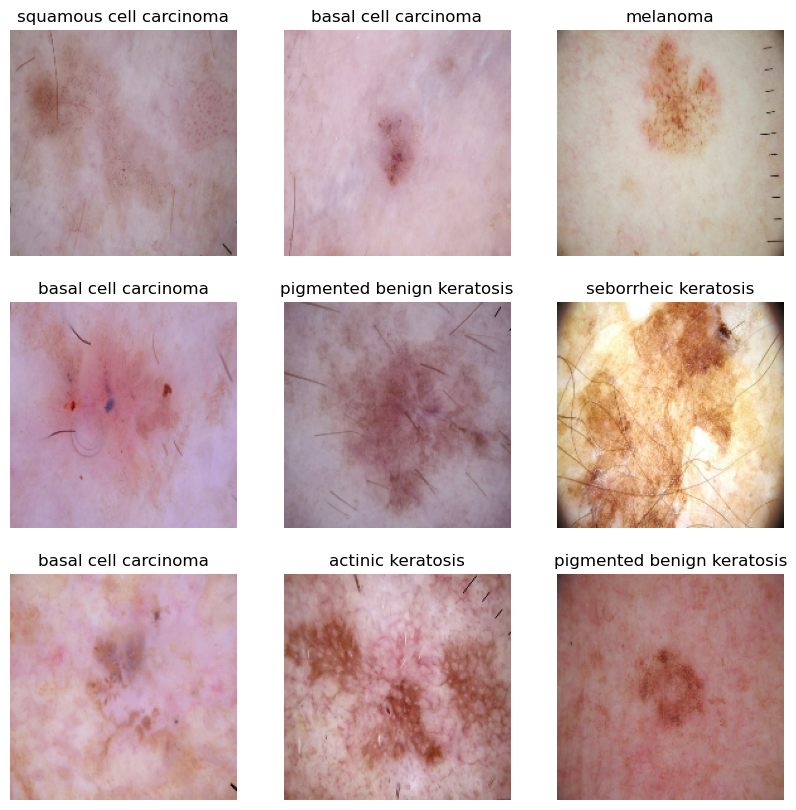

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [76]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

In [80]:
num_classes = 9 # As target class has 9 labels

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [63]:
# Choose an appropirate optimiser and loss function.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [51]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [54]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 72s 373ms/step - accuracy: 0.1692 - loss: 2.4827 - val_accuracy: 0.3972 - val_loss: 1.5578
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 61s 364ms/step - accuracy: 0.4111 - loss: 1.5314 - val_accuracy: 0.4996 - val_loss: 1.3525
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 63s 373ms/step - accuracy: 0.5322 - loss: 1.2875 - val_accuracy: 0.5776 - val_loss: 1.1720
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 381ms/step - accuracy: 0.5973 - loss: 1.0867 - val_accuracy: 0.6229 - val_loss: 1.0301
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 67s 396ms/step - accuracy: 0.6528 - loss: 0.9285 - val_accuracy: 0.7030 - val_loss: 0.8646
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 377ms/step - accuracy: 0.7395 - loss: 0.7083 - val_accuracy: 0.6897 - val_loss: 0.8628
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 65s 383ms/step - accuracy: 0.7819 - loss: 0.5951 - val_accuracy: 0.6563 - val_loss: 1.0414
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 67s 394ms/step - accuracy: 0.8193 - loss: 0

### Visualizing training results

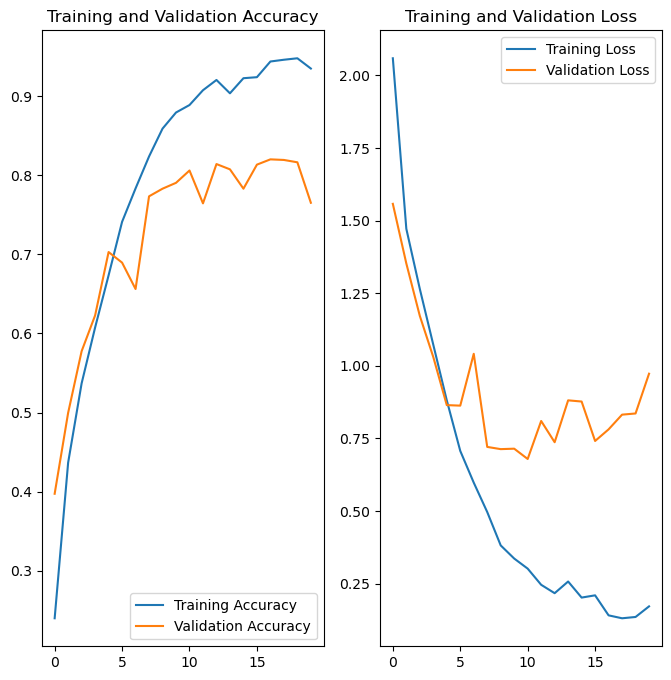

In [83]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observation Recap
- The training accuracy of the model shows a linear increase, while the validation accuracy remains stagnant around 55%. This indicates that the model is learning the noise in the training data, leading to high training accuracy but poor performance on the validation set, highlighting a lack of generalization.

- These observations confirm that the model is overfitting. To address this, data augmentation will be applied. Given the limited training data, new samples will be generated by introducing slight modifications to the existing training data. Examples of these modifications include flipping images horizontally or vertically, rotating them slightly, and other transformations. These augmented samples will then be incorporated into the training process to enhance the model's ability to generalize.

In [87]:
# As model is overfit, applying appropriate data augumentation strategy. 
data_augmentation = keras.Sequential([
      layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
      layers.RandomRotation(0.1),
      layers.RandomZoom(0.1),
])

2025-01-15 18:28:41.834327: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


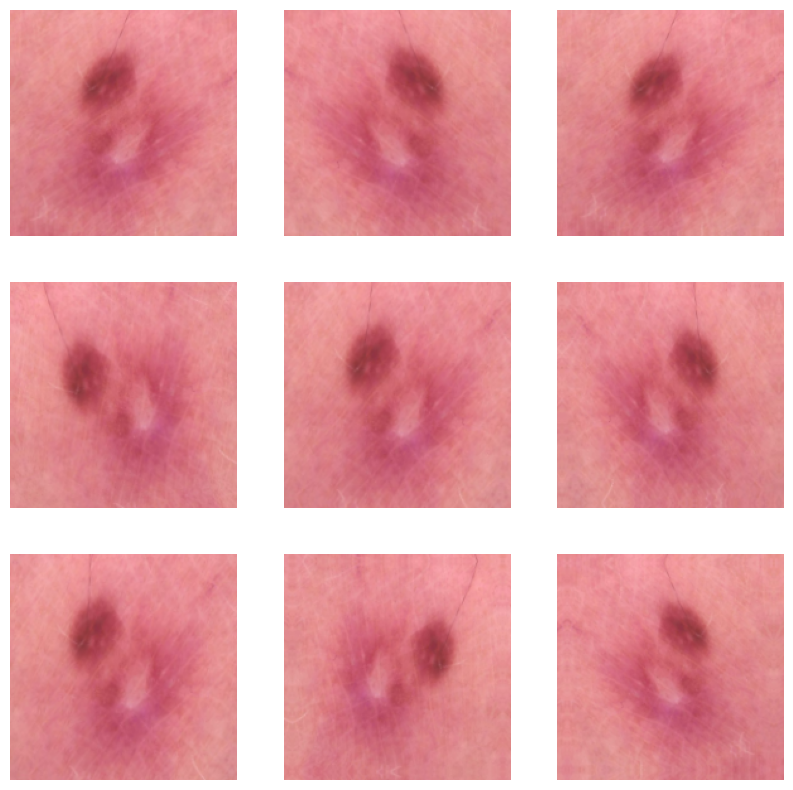

In [89]:
# Visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model, compile and train the model

In [94]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes)
])

### Compiling the model

In [97]:
model.compile(optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)     

### Training the model

In [100]:
## Train model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 82s 474ms/step - accuracy: 0.1829 - loss: 2.1485 - val_accuracy: 0.3764 - val_loss: 1.6679
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 77s 455ms/step - accuracy: 0.3755 - loss: 1.6510 - val_accuracy: 0.4232 - val_loss: 1.4959
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 472ms/step - accuracy: 0.4588 - loss: 1.4700 - val_accuracy: 0.4929 - val_loss: 1.3621
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 81s 478ms/step - accuracy: 0.4573 - loss: 1.4167 - val_accuracy: 0.5160 - val_loss: 1.2448
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 85s 502ms/step - accuracy: 0.4877 - loss: 1.3672 - val_accuracy: 0.5278 - val_loss: 1.2270
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 86s 511ms/step - accuracy: 0.4991 - loss: 1.3079 - val_accuracy: 0.5412 - val_loss: 1.1589
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 85s 504ms/step - accuracy: 0.4872 - loss: 1.3023 - val_accuracy: 0.5479 - val_loss: 1.1833
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 85s 505ms/step - accuracy: 0.5148 - loss: 1

### Visualizing the results

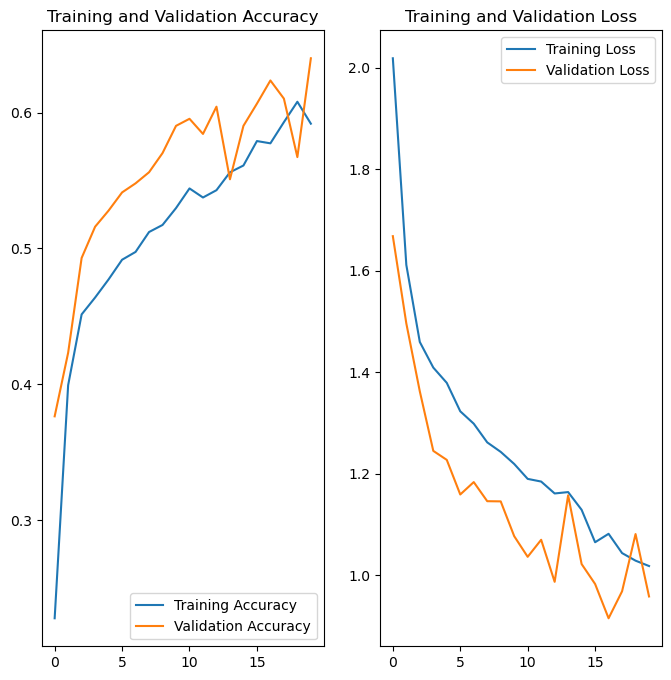

In [128]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations:
- The use of augmented data has successfully mitigated the problem of overfitting.
- Training and validation accuracies are now within a similar range, indicating better generalization.
- However, the model is now underfitting, as it performs poorly on both training and validation data.

#### Find the distribution of classes in the training dataset.

In [132]:
from glob import glob
path_list = [ x for x in glob(os.path.join(data_dir_train, '*', '*.jpg')) ] 
lesion_list = [ os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesion_list))

2239


In [134]:
df_dict_original = dict(zip(path_list, lesion_list))
print(list(df_dict_original.items())[:2])

[('Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0010550.jpg', 'melanoma'), ('Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0011128.jpg', 'melanoma')]


In [136]:
original_df = pd.DataFrame(list(df_dict_original.items()), columns=['Path','Label'])
original_df.head()

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,melanoma
1,Skin cancer ISIC The International Skin Imagin...,melanoma
2,Skin cancer ISIC The International Skin Imagin...,melanoma
3,Skin cancer ISIC The International Skin Imagin...,melanoma
4,Skin cancer ISIC The International Skin Imagin...,melanoma


In [138]:
original_df[['Label']].value_counts()

Label                     
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

In [140]:
original_df[['Label']].value_counts(normalize=True)

Label                     
pigmented benign keratosis    0.206342
melanoma                      0.195623
basal cell carcinoma          0.167932
nevus                         0.159446
squamous cell carcinoma       0.080840
vascular lesion               0.062081
actinic keratosis             0.050916
dermatofibroma                0.042430
seborrheic keratosis          0.034390
Name: proportion, dtype: float64

### Observations:
- **'Seborrheic keratosis'** has the least number of samples.
- The classes **'pigmented benign keratosis'** and **'melanoma'** dominate the dataset with **20.6%** and **19.5%** of the samples, respectively.

#### Rectify the class imbalance

In [145]:
# !pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [148]:
path_to_training_dataset = str(data_dir_train) + '/'

import Augmentor

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1707DFD50>: 100%|█|


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16FFC1A10>: 100%|█|


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x16E716510>: 100%|█


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x1


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x170C39410>: 100%|█|


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x170C39410>: 100%|█


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1709A4490>: 100%|█|


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16E4E8050>: 100%|█|


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [151]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [154]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000149.jpg_3c39b05d-77da-4c9c-8ef8-85d64ef4c345.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010016.jpg_5ab73819-9eb1-4257-83cf-123f53aaa8a5.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001142.jpg_23f68147-a58e-48dc-a3ee-d49aa5655cdc.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010482.jpg_37101b97-72c8-463b-9495-c9e28ca3a697.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010777.jpg_baf89044-4866-4136-9fb0-c35b7d833b7e.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009934.jpg_87814209-5c61-4746-a549-1e3398b20efe.jpg',
 'Skin cancer IS

In [156]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [158]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [160]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns=['Path', 'Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

In [162]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    1462
melanoma                      1438
basal cell carcinoma          1376
nevus                         1357
squamous cell carcinoma       1181
vascular lesion               1139
actinic keratosis             1114
dermatofibroma                1095
seborrheic keratosis          1077
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [166]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [181]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### Create a validation dataset

In [184]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### Create your model (make sure to include normalization)

In [186]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes)
])

#### Compile your model (Choose optimizer and loss function appropriately)

In [190]:
model.compile(optimizer='adam',
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy']
)

#### Train your model

In [192]:
epochs = 30

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 236s 832ms/step - accuracy: 0.2126 - loss: 2.5206 - val_accuracy: 0.3587 - val_loss: 1.6194
Epoch 2/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 254s 903ms/step - accuracy: 0.3732 - loss: 1.6206 - val_accuracy: 0.4704 - val_loss: 1.4022
Epoch 3/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 259s 920ms/step - accuracy: 0.4232 - loss: 1.4847 - val_accuracy: 0.3725 - val_loss: 1.7408
Epoch 4/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 273s 970ms/step - accuracy: 0.4498 - loss: 1.4113 - val_accuracy: 0.4348 - val_loss: 1.4981
Epoch 5/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 240s 854ms/step - accuracy: 0.4656 - loss: 1.3721 - val_accuracy: 0.5768 - val_loss: 1.1179
Epoch 6/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 249s 886ms/step - accuracy: 0.4977 - loss: 1.2875 - val_accuracy: 0.5376 - val_loss: 1.2209
Epoch 7/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 245s 873ms/step - accuracy: 0.5248 - loss: 1.2550 - val_accuracy: 0.5919 - val_loss: 1.1011
Epoch 8/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 252s 897ms/step - accuracy: 0.5302 -

#### Visualize the model results

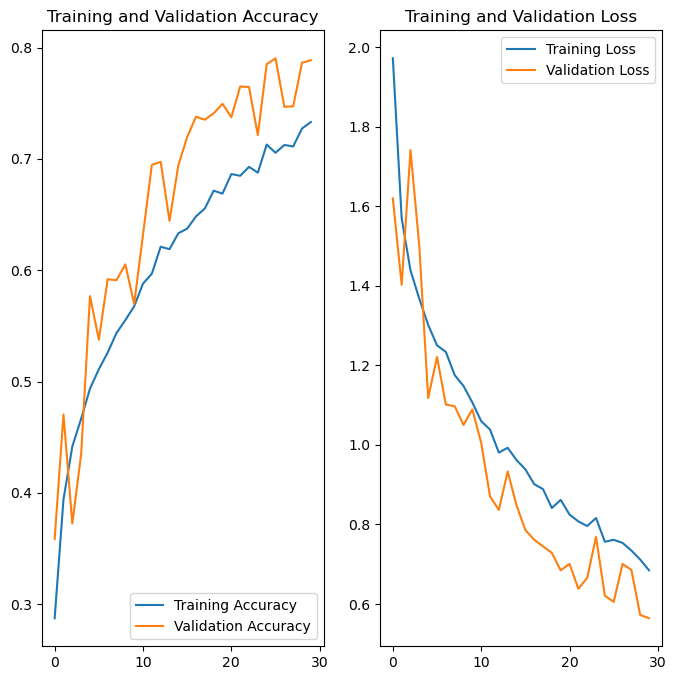

In [194]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Final Observations:
- The final model shows no signs of underfitting or overfitting.
- Class rebalancing has improved the model's performance on both training and validation data.
- After 30 epochs, the final model achieves 80% training accuracy and 77% validation accuracy.
- The small difference between training and validation accuracy indicates that the final CNN model generalizes well.
- Inclusion of batch normalization reduces the model's accuracy, so it is not included in the final model.
